In [124]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from selenium import webdriver
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [125]:
def get_teams_url():
    home_url = "https://www.basketball-reference.com"
    data = requests.get(home_url)
    soup = BeautifulSoup(data.content, "lxml")
    teams_html = soup.find('div',id='teams')
    teams_option = teams_html.find_all('option')[1:31]
    teams = []
    for each_option in teams_option:
        teams.append(each_option.get('value'))
    
    return teams

In [126]:
def get_header():
    
    first_team_url = get_teams_url()
    team_url= "https://www.basketball-reference.com" + first_team_url[0] + "/2022.html"
    data = requests.get(team_url)
    soup = BeautifulSoup(data.content, "lxml")
    h = soup.find('table', id="per_game")
    h1= h.find('tr')
    h2 = h1.find_all('th')[2:28]
    header = []
    for each_th in h2:
        each_th.text.replace(' ', '')
        header.append(each_th.text)
    
    return header


#team_url= "https://www.basketball-reference.com" + first_team_url[0] + "/2022.html"

In [127]:
header = get_header()
header[0:3]

['Age', 'G', 'GS']

In [12]:
#function that download every team html page using selenium
def get_all_teams_html(year):
    
    teams_url = get_teams_url()
    for each_url in teams_url:
        team_url = "https://www.basketball-reference.com" + each_url + "/" + str(year) + ".html"
        d_url = each_url.replace('/teams', '')
        driver = webdriver.Chrome(executable_path = '/Users/giacomosanguin/Documents/Chromedriver/chromedriver')
        driver.get(team_url)
        driver.execute_script("window.scrollTo(1,10000)")
        time.sleep(3)

        with open("teams{}.html".format(d_url+str(year)), "w+") as f:
            f.write(driver.page_source)

In [13]:
get_all_teams_html(2022)

/var/folders/l0/y1l_6gn11djdvs2mblwp0jtw0000gn/T/ipykernel_18935/335794998.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path = '/Users/giacomosanguin/Documents/Chromedriver/chromedriver')


In [128]:
header = get_header()
teams_url = get_teams_url()
#creating a list that will contain all the stats of every player in the league
stats = []
#per every team in the league
for each_url in teams_url:
    #team_url = "https://www.basketball-reference.com" + each_url + "/" + str(year) + ".html"
    #open the respective file
    d_url = each_url.replace('/teams', '')
    team_name = each_url.replace('/teams/', '')
    with open("teams{}.html".format(d_url+str(2022))) as f:
        page = f.read()
    #parsing with BeautifulSoup
    soup = BeautifulSoup(page, 'lxml')
    tab_per_game= soup.find('table', id="per_game")
    per_game = tab_per_game.find_all('tr')[1:]
    #creating the list that will contain only the stats of the singular player
    stats_player = []
    name = []
    #per every player at roster
    for each_tr in per_game:
        #creating a dictionary that will contain players and their respective stats
        players = {}
        players['Name'] = each_tr.find('a').text
        players['Team'] = team_name
        name = each_tr.find('a').text
        per_game2 = each_tr.find_all('td')[1:]
        for each_td in per_game2:
            stats_player.append(each_td.text)
        for n in range(1,26):
            players[header[n]] = stats_player[n]
        
        #getting the salary of every player
        salary = soup.find('table', id='salaries2')
        sal_play = salary.find_all('tr')[1:]
        
        #checking if there is a tr row we need to decompose
        problem = salary.select("tr.thead") 
        if problem: 
            salary.find('tr', class_='thead').decompose()
            sal_play2 = salary.find_all('tr')[1:]
            for each_trr in sal_play2:
                if each_trr.find('a').text == name :
                    
                    sal = each_trr.find_all('td')[1:]
                    salario = sal[0].text.replace('$', '')
                    salario_def = salario.replace(',', '')
                    
                    players['Salary'] = salario_def
        else:
            for each_trr in sal_play:
                if each_trr.find('a').text == name :
                    
                    sal = each_trr.find_all('td')[1:]
                    salario = sal[0].text.replace('$', '')
                    salario_def = salario.replace(',', '')
                    
                    players['Salary'] = salario_def
                
        
        #adding the dictionary to the list containing all the stats of every player in the league
        stats.append(players)
        #clearing the list containing the stats of the player so that it's empty for the next one
        stats_player.clear()        
#creating the dataframe containing all the stats
nba_all_players_stats = pd.DataFrame(stats)
nba_all_players_stats

,Name,Team,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS/G,Salary
0,Trae Young,ATL,76,76,34.9,9.4,20.3,.460,3.1,8.0,...,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,8326471
1,John Collins,ATL,54,53,30.8,6.3,11.9,.526,1.2,3.3,...,1.7,6.1,7.8,1.8,0.6,1.0,1.1,3.0,16.2,23000000
2,De'Andre Hunter,ATL,53,52,29.8,4.8,10.8,.442,1.4,3.7,...,0.5,2.8,3.3,1.3,0.7,0.4,1.3,2.9,13.4,7775400
3,Kevin Huerter,ATL,74,60,29.6,4.7,10.3,.454,2.2,5.6,...,0.4,3.0,3.4,2.7,0.7,0.4,1.2,2.5,12.1,4253357
4,Bogdan Bogdanović,ATL,63,27,29.3,5.4,12.6,.431,2.7,7.3,...,0.5,3.5,4.0,3.1,1.1,0.2,1.1,2.1,15.1,18000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,Alize Johnson,WAS,3,0,6.0,0.7,2.0,.333,0.0,0.7,...,1.7,2.3,4.0,0.0,0.0,0.0,1.0,0.0,1.3,99380
711,Cassius Winston,WAS,7,0,5.6,0.6,1.6,.364,0.3,0.9,...,0.0,0.1,0.1,1.0,0.0,0.0,0.4,1.3,2.0,0
712,Jordan Goodwin,WAS,2,0,3.0,0.0,1.5,.000,0.0,0.5,...,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,53176
713,Jaime Echenique,WAS,1,0,3.0,0.0,0.0,,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53176


In [181]:
def object_to_num(nba):
    
    str_cols = ['Name', 'Team', 'Age']
    
    for i in nba.columns:
        if i not in str_cols:
            nba[i] = pd.to_numeric(nba[i])
    
    print(nba.dtypes)

In [182]:
object_to_num(nba_all_players_stats)

Name        object
Team        object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS/G      float64
Salary     float64
credits    float64
AV         float64
dtype: object


In [133]:
#funtion that select the stats of a singular player
def get_player_stats(player):
    
    return nba_all_players_stats[nba_all_players_stats['Name'] == player]   

In [134]:
get_player_stats('Trae Young')

,Name,Team,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS/G,Salary
0,Trae Young,ATL,76,76,34.9,9.4,20.3,0.46,3.1,8.0,...,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4,8326471


In [135]:
#function that select the singular statistic of a determined player
def get_player_stat(player, stat):
    return nba_all_players_stats.loc[nba_all_players_stats['Name']== player, [stat]] 

In [136]:
get_player_stat('Trae Young', '3P%')

,3P%
0,0.382


/Users/giacomosanguin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


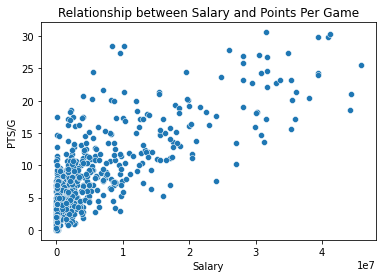

In [183]:
#Plotting the relationship between the salary of a player and his points per game
sns.scatterplot(nba_all_players_stats['Salary'], nba_all_players_stats['PTS/G'])
plt.title('Relationship between Salary and Points Per Game');

In [178]:
nba_all_players_stats['credits'] = nba_all_players_stats['PTS/G'] + nba_all_players_stats['TRB'] + nba_all_players_stats['AST'] + nba_all_players_stats['STL'] + nba_all_players_stats['BLK'] + nba_all_players_stats['FT'] - nba_all_players_stats['FTA'] + nba_all_players_stats['FG'] - nba_all_players_stats['FGA'] - nba_all_players_stats['TOV']
nba_all_players_stats['AV'] = (nba_all_players_stats['credits'] ** 0.75) /21
nba_all_players_stats



,Name,Team,G,GS,MP,FG,FGA,FG%,3P,3PA,...,TRB,AST,STL,BLK,TOV,PF,PTS/G,Salary,credits,AV
0,Trae Young,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,...,3.7,9.7,0.9,0.1,4.0,1.7,28.4,8326471,27.2,0.567162
1,John Collins,ATL,54,53,30.8,6.3,11.9,0.526,1.2,3.3,...,7.8,1.8,0.6,1.0,1.1,3.0,16.2,23000000,20.1,0.452041
2,De'Andre Hunter,ATL,53,52,29.8,4.8,10.8,0.442,1.4,3.7,...,3.3,1.3,0.7,0.4,1.3,2.9,13.4,7775400,11.1,0.289583
3,Kevin Huerter,ATL,74,60,29.6,4.7,10.3,0.454,2.2,5.6,...,3.4,2.7,0.7,0.4,1.2,2.5,12.1,4253357,12.4,0.314664
4,Bogdan Bogdanović,ATL,63,27,29.3,5.4,12.6,0.431,2.7,7.3,...,4.0,3.1,1.1,0.2,1.1,2.1,15.1,18000000,14.9,0.361136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,Alize Johnson,WAS,3,0,6.0,0.7,2.0,0.333,0.0,0.7,...,4.0,0.0,0.0,0.0,1.0,0.0,1.3,99380,2.7,0.100301
711,Cassius Winston,WAS,7,0,5.6,0.6,1.6,0.364,0.3,0.9,...,0.1,1.0,0.0,0.0,0.4,1.3,2.0,0,1.7,0.070895
712,Jordan Goodwin,WAS,2,0,3.0,0.0,1.5,0.000,0.0,0.5,...,0.5,0.0,0.0,0.0,0.0,0.5,0.0,53176,-1.0,NaN
713,Jaime Echenique,WAS,1,0,3.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53176,0.0,0.000000


In [190]:
j = nba_all_players_stats['AV'].max()
nba_all_players_stats.loc[nba_all_players_stats['AV']==j, ['Name']]

,Name
170,Nikola Jokić


In [185]:
nba_all_players_stats['Salary (mln)'] = (nba_all_players_stats['Salary'])/ 1000000
nba_all_players_stats

,Name,Team,G,GS,MP,FG,FGA,FG%,3P,3PA,...,AST,STL,BLK,TOV,PF,PTS/G,Salary,credits,AV,Salary (mln)
0,Trae Young,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,...,9.7,0.9,0.1,4.0,1.7,28.4,8326471.0,27.2,0.567162,8.326471
1,John Collins,ATL,54,53,30.8,6.3,11.9,0.526,1.2,3.3,...,1.8,0.6,1.0,1.1,3.0,16.2,23000000.0,20.1,0.452041,23.000000
2,De'Andre Hunter,ATL,53,52,29.8,4.8,10.8,0.442,1.4,3.7,...,1.3,0.7,0.4,1.3,2.9,13.4,7775400.0,11.1,0.289583,7.775400
3,Kevin Huerter,ATL,74,60,29.6,4.7,10.3,0.454,2.2,5.6,...,2.7,0.7,0.4,1.2,2.5,12.1,4253357.0,12.4,0.314664,4.253357
4,Bogdan Bogdanović,ATL,63,27,29.3,5.4,12.6,0.431,2.7,7.3,...,3.1,1.1,0.2,1.1,2.1,15.1,18000000.0,14.9,0.361136,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,Alize Johnson,WAS,3,0,6.0,0.7,2.0,0.333,0.0,0.7,...,0.0,0.0,0.0,1.0,0.0,1.3,99380.0,2.7,0.100301,0.099380
711,Cassius Winston,WAS,7,0,5.6,0.6,1.6,0.364,0.3,0.9,...,1.0,0.0,0.0,0.4,1.3,2.0,0.0,1.7,0.070895,0.000000
712,Jordan Goodwin,WAS,2,0,3.0,0.0,1.5,0.000,0.0,0.5,...,0.0,0.0,0.0,0.0,0.5,0.0,53176.0,-1.0,NaN,0.053176
713,Jaime Echenique,WAS,1,0,3.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53176.0,0.0,0.000000,0.053176


/Users/giacomosanguin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


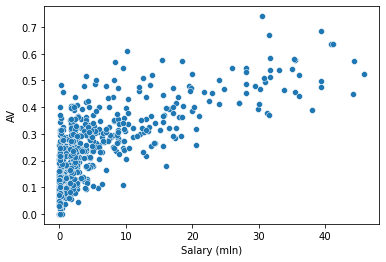

In [186]:
sns.scatterplot(nba_all_players_stats['Salary (mln)'], nba_all_players_stats['AV'])
plt.title('');

/Users/giacomosanguin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


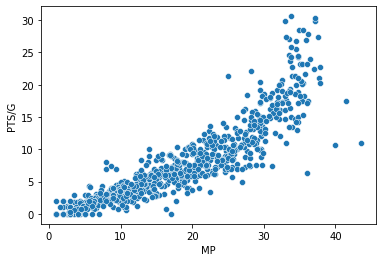

In [179]:
sns.scatterplot(nba_all_players_stats['MP'], nba_all_players_stats['PTS/G'])
plt.title('');